In [1]:
import zipfile
from google.colab import drive
import os

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
zip_file='/content/drive/MyDrive/datasetJetBrains.zip'
z=zipfile.ZipFile(zip_file,'r')
z.extractall()
print (os.listdir())

['.config', 'drive', 'test.csv', 'train.csv', 'sample_submission.csv', 'sample_data']


In [4]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [5]:
import pandas as pd
import nltk
nltk.download('stopwords')
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords 
import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers as L
import tensorflow as tf
from sklearn import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
import re
import pickle
import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
from collections import Counter
from string import punctuation
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
from scipy.sparse import hstack
import keras.backend as K
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from scipy.sparse import csr_matrix
#import tokenization
#from keras_bert import load_trained_model_from_checkpoint, load_vocabulary

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
df_train=pd.read_csv('/content/train.csv',index_col='ID')

In [7]:
df_test=pd.read_csv('/content/test.csv',index_col='ID')

In [8]:
df_test

,TITLE,ABSTRACT
ID,,
20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...
20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...
20975,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...
20976,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...
20977,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...
...,...,...
29957,Supporting mixed-datatype matrix multiplicatio...,We approach the problem of implementing mixe...
29958,An axiomatic basis for Blackwell optimality,In the theory of Markov decision processes (...
29959,GeneVis - An interactive visualization tool fo...,GeneVis is a web-based tool to visualize com...


In [9]:
df_train

,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
ID,,,,,,,,
1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...
20968,Contemporary machine learning: a guide for pra...,Machine learning is finding increasingly bro...,1,1,0,0,0,0
20969,Uniform diamond coatings on WC-Co hard alloy c...,Polycrystalline diamond coatings have been g...,0,1,0,0,0,0
20970,Analysing Soccer Games with Clustering and Con...,We present a new approach for identifying si...,1,0,0,0,0,0


In [10]:
df_train.apply(lambda x: x.count())

TITLE                   20972
ABSTRACT                20972
Computer Science        20972
Physics                 20972
Mathematics             20972
Statistics              20972
Quantitative Biology    20972
Quantitative Finance    20972
dtype: int64

In [11]:
labels=['Computer Science','Physics','Mathematics','Statistics','Quantitative Biology','Quantitative Finance']

# 1.EDA

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


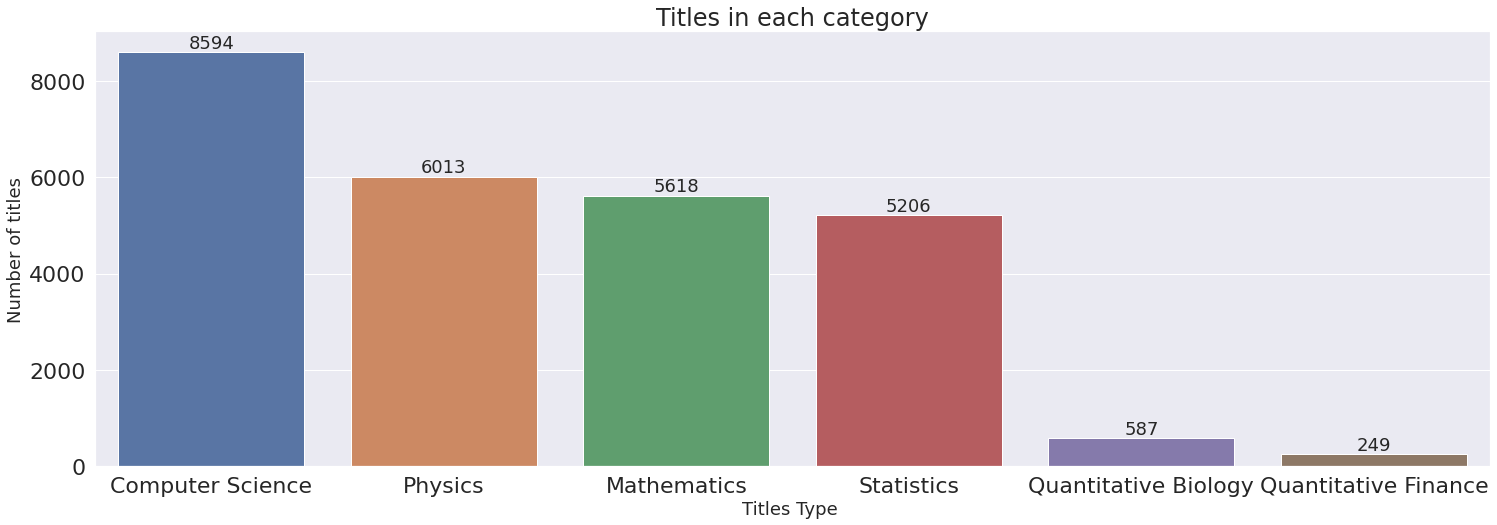

In [12]:
#посмотрим количество текстов относящихся к каждой категории

sns.set_theme(font_scale = 2)
plt.figure(figsize=(25,8))
ax= sns.barplot(labels, df_train.iloc[:,2:].sum().values)
plt.title("Titles in each category", fontsize=24)
plt.ylabel('Number of titles', fontsize=18)
plt.xlabel('Titles Type ', fontsize=18)
rects = ax.patches
class_labels = df_train.iloc[:,2:].sum().values
for rect, label in zip(rects, class_labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


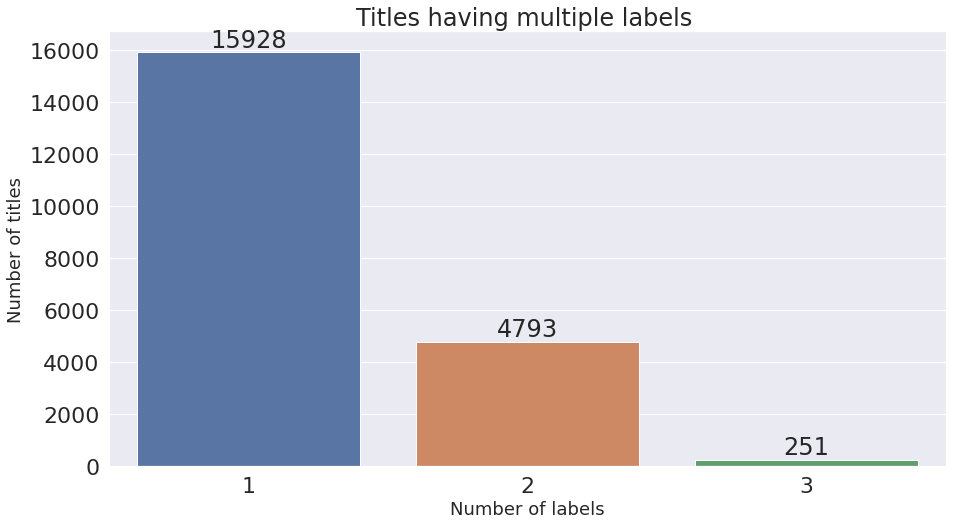

In [13]:
#посмотрим количество текстов относящимся к 1,2,.. категориям
rowSums = df_train.iloc[:,2:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
sns.set_theme(font_scale = 2)
plt.figure(figsize=(15,8))
ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
plt.title("Titles having multiple labels ")
plt.ylabel('Number of titles', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)#adding the text labels
rects = ax.patches
labels_count = multiLabel_counts.values
for rect, label in zip(rects, labels_count):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

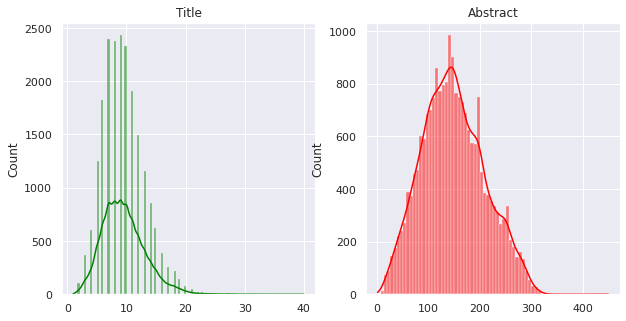

In [14]:
#посмотрим распределение количество слов в TITLE и ABSTRACT
sns.set_theme()
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
ax1.set_title('Title')
ax2.set_title('Abstract')
text_len_title=[]
text_len_abstract=[]
for title,abstract in zip(df_train['TITLE'].values,df_train['ABSTRACT'].values):
    text_len_title.append(len(title.split()))
    text_len_abstract.append(len(abstract.split()))
sns.histplot(text_len_title,kde=True,ax=ax1,color='green')
sns.histplot(text_len_abstract,kde=True,ax=ax2,color='red')

In [15]:
def create_corpus_title(category):
    corpus_title=[]
    for x in df_train[df_train[category]==1]['TITLE'].str.split():
        for i in x:
            corpus_title.append(i)
    return corpus_title

In [16]:
def top_stopwords_title(category):
  stopwords_title=[]
  for word in create_corpus_title(category):
    if word in stopwords.words('english'):
      stopwords_title.append(word)
  d=dict((x, stopwords_title.count(x)) for x in set(stopwords_title) if stopwords_title.count(x) > 1)
  top=sorted(d.items(), key=lambda x:x[1],reverse=True)[:10] 
  x,y=zip(*top)
  return x,y

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


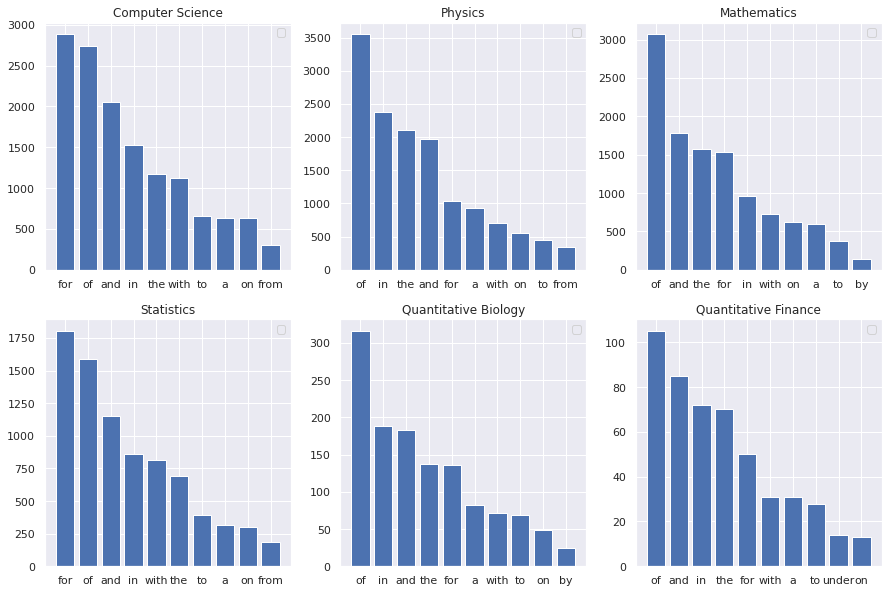

In [17]:
fig, axes = plt.subplots(2, 3,figsize=(15,10))
for i,label in enumerate (labels):
  x,y=top_stopwords_title(label)
  axes[i//3,i%3].legend()
  axes[i//3,i%3].set_title(label)
  axes[i//3,i%3].bar(x,y)

  

In [18]:
def create_corpus_abstract(category):
    corpus_title=[]
    for x in df_train[df_train[category]==1]['ABSTRACT'].str.split():
        for i in x:
            corpus_title.append(i)
    return corpus_title

In [19]:
def top_stopwords_abstract(category):
  stopwords_abstract=[]
  for word in create_corpus_abstract(category):
    if word in stopwords.words('english'):
      stopwords_abstract.append(word)
  d=dict((x, stopwords_abstract.count(x)) for x in set(stopwords_abstract) if stopwords_abstract.count(x) > 1)
  top=sorted(d.items(), key=lambda x:x[1],reverse=True)[:10] 
  x,y=zip(*top)
  return x,y

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


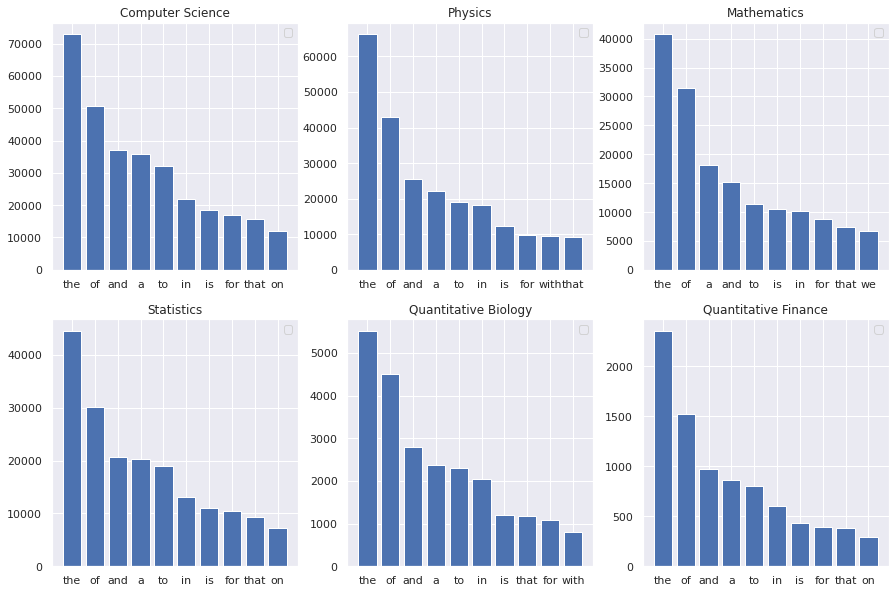

In [20]:
fig, axes = plt.subplots(2, 3,figsize=(15,10))
for i,label in enumerate (labels):
  x,y=top_stopwords_abstract(label)
  axes[i//3,i%3].legend()
  axes[i//3,i%3].set_title(label)
  axes[i//3,i%3].bar(x,y)

In [21]:
def top_punctuation_title(category):
  punctuations_title=[]
  for word in create_corpus_title(category):
    if word in punctuation:
      punctuations_title.append(word)
  d=dict((x, punctuations_title.count(x)) for x in set(punctuations_title) if punctuations_title.count(x) > 1)
  top=sorted(d.items(), key=lambda x:x[1],reverse=True)[:10] 
  x,y=zip(*top)
  return x,y

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


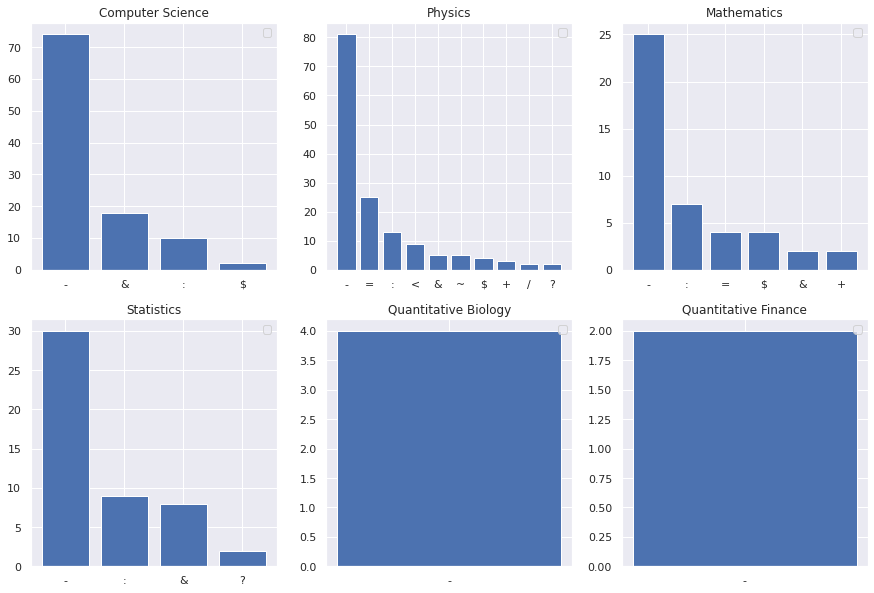

In [22]:
fig, axes = plt.subplots(2, 3,figsize=(15,10))
for i,label in enumerate (labels):
  x,y=top_punctuation_title(label)
  axes[i//3,i%3].legend()
  axes[i//3,i%3].set_title(label)
  axes[i//3,i%3].bar(x,y)

In [23]:
def top_punctuation_abstract(category):
  punctuation_abstract=[]
  for word in create_corpus_abstract(category):
    if word in punctuation:
      punctuation_abstract.append(word)
  d=dict((x, punctuation_abstract.count(x)) for x in set(punctuation_abstract) if punctuation_abstract.count(x) > 1)
  top=sorted(d.items(), key=lambda x:x[1],reverse=True)[:10] 
  x,y=zip(*top)
  return x,y

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


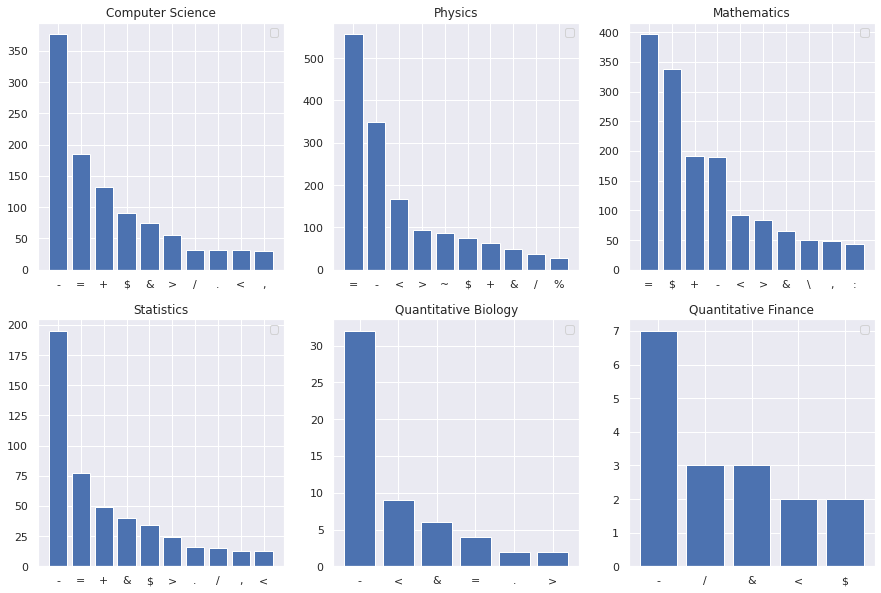

In [24]:
fig, axes = plt.subplots(2, 3,figsize=(15,10))
for i,label in enumerate (labels):
  x,y=top_punctuation_abstract(label)
  axes[i//3,i%3].legend()
  axes[i//3,i%3].set_title(label)
  axes[i//3,i%3].bar(x,y)

In [25]:
def top_first_word_title(df,category):
  first_word_title=[]
  for seq in df[df[category]==1]['TITLE'].str.split():
    first_word_title.append(seq[0].lower())
  d=dict((x, first_word_title.count(x)) for x in set(first_word_title) if first_word_title.count(x) > 1)
  top=sorted(d.items(), key=lambda x:x[1],reverse=True)[:10] 
  x,y=zip(*top)
  return x,y

In [26]:
def top_first_word_abstract(df,category):
  first_word_abstract=[]
  for seq in df[df[category]==1]['ABSTRACT'].str.split():
    first_word_abstract.append(seq[0].lower())
  d=dict((x, first_word_abstract.count(x)) for x in set(first_word_abstract) if first_word_abstract.count(x) > 1)
  top=sorted(d.items(), key=lambda x:x[1],reverse=True)[:10] 
  x,y=zip(*top)
  return x,y

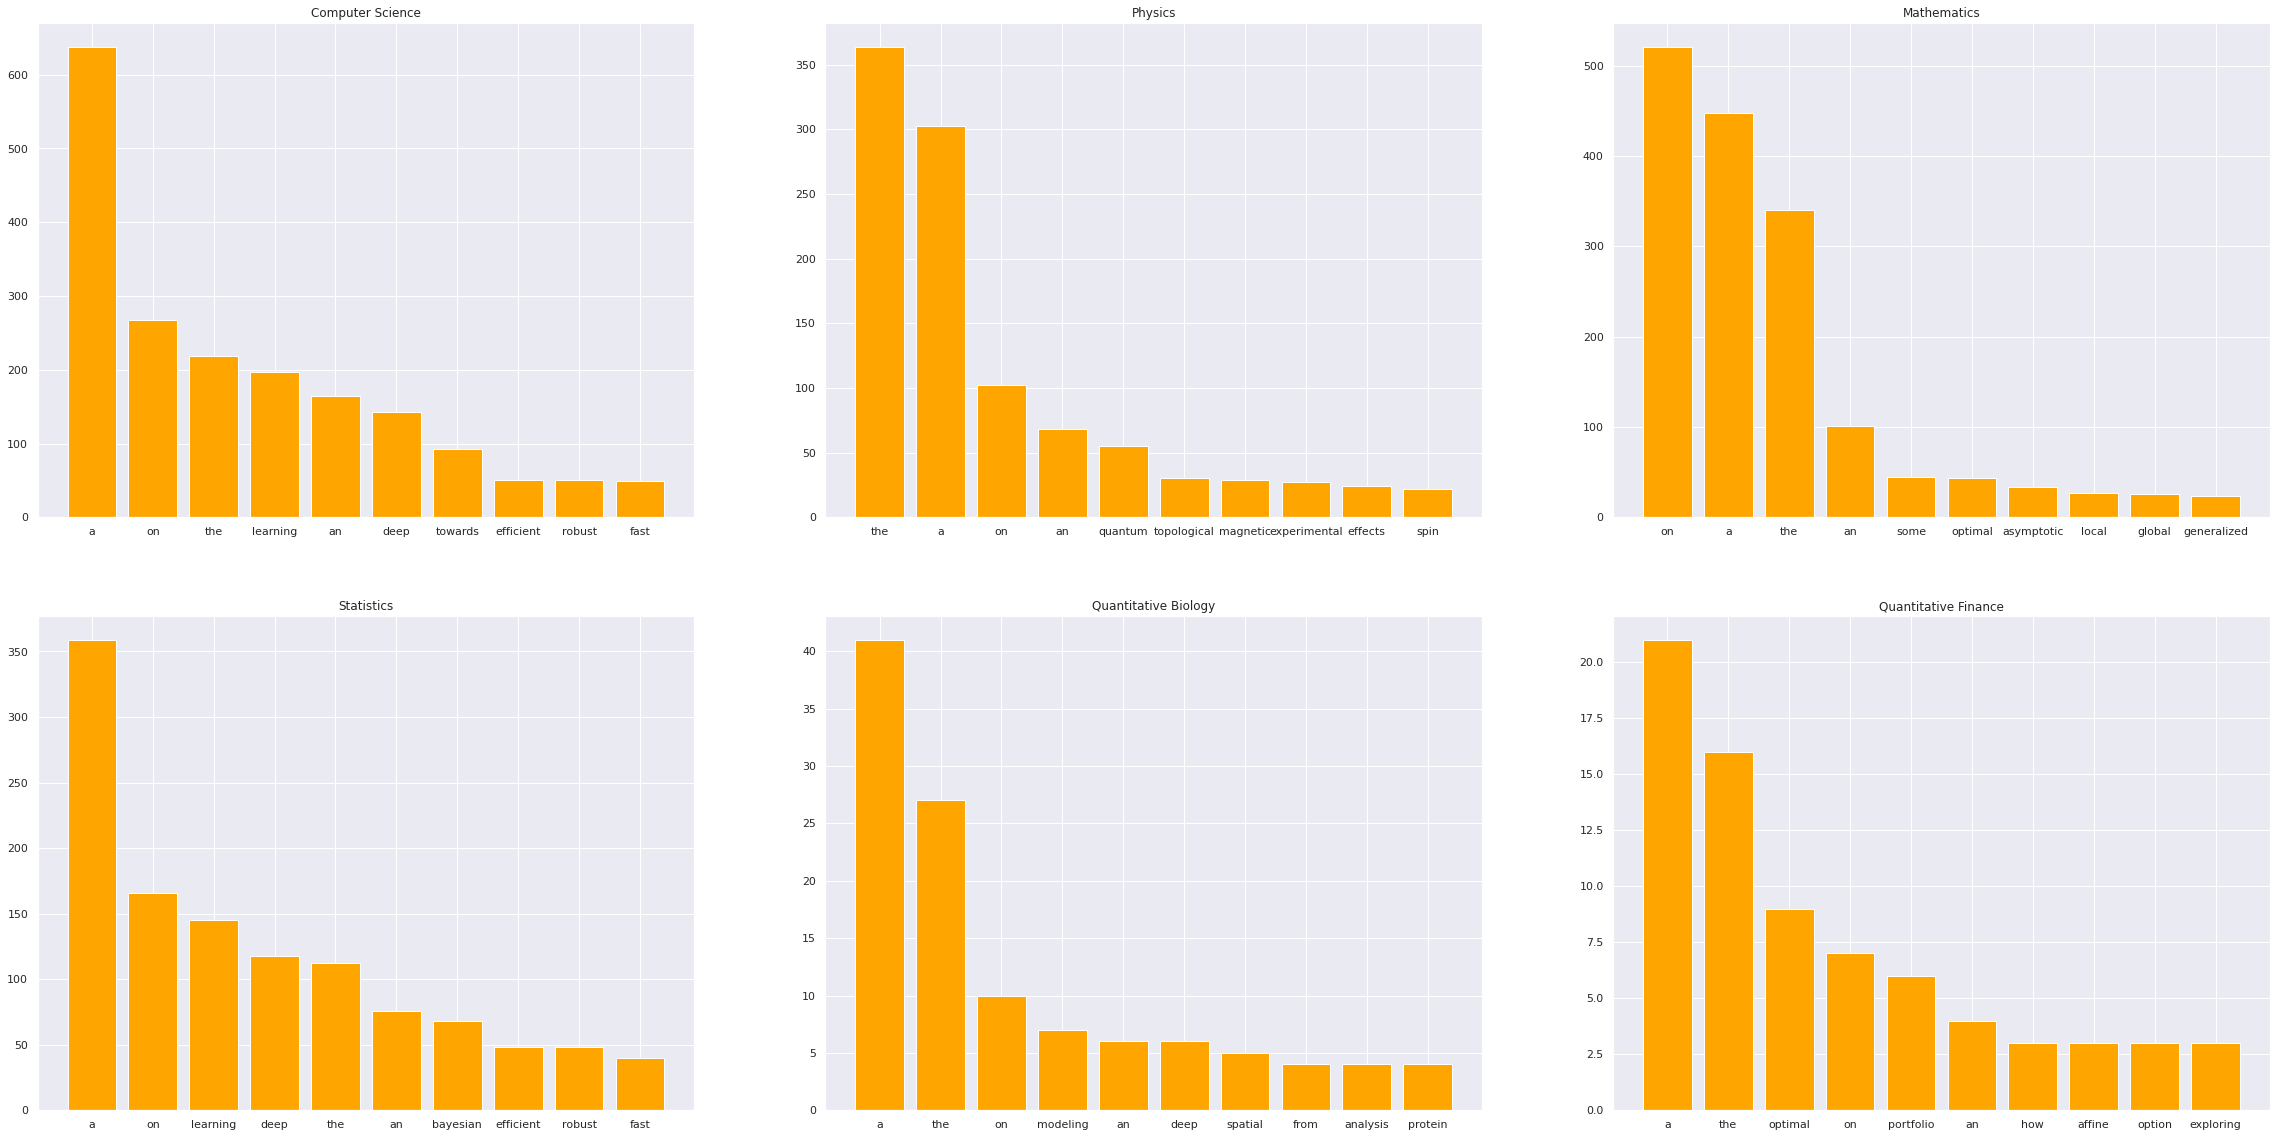

In [27]:
fig, axes = plt.subplots(2, 3,figsize=(40,20))
for i,label in enumerate (labels):
  x,y=top_first_word_title(df_train,label)
  axes[i//3,i%3].set_title(label)
  axes[i//3,i%3].bar(x,y,width = 0.8,color='orange')

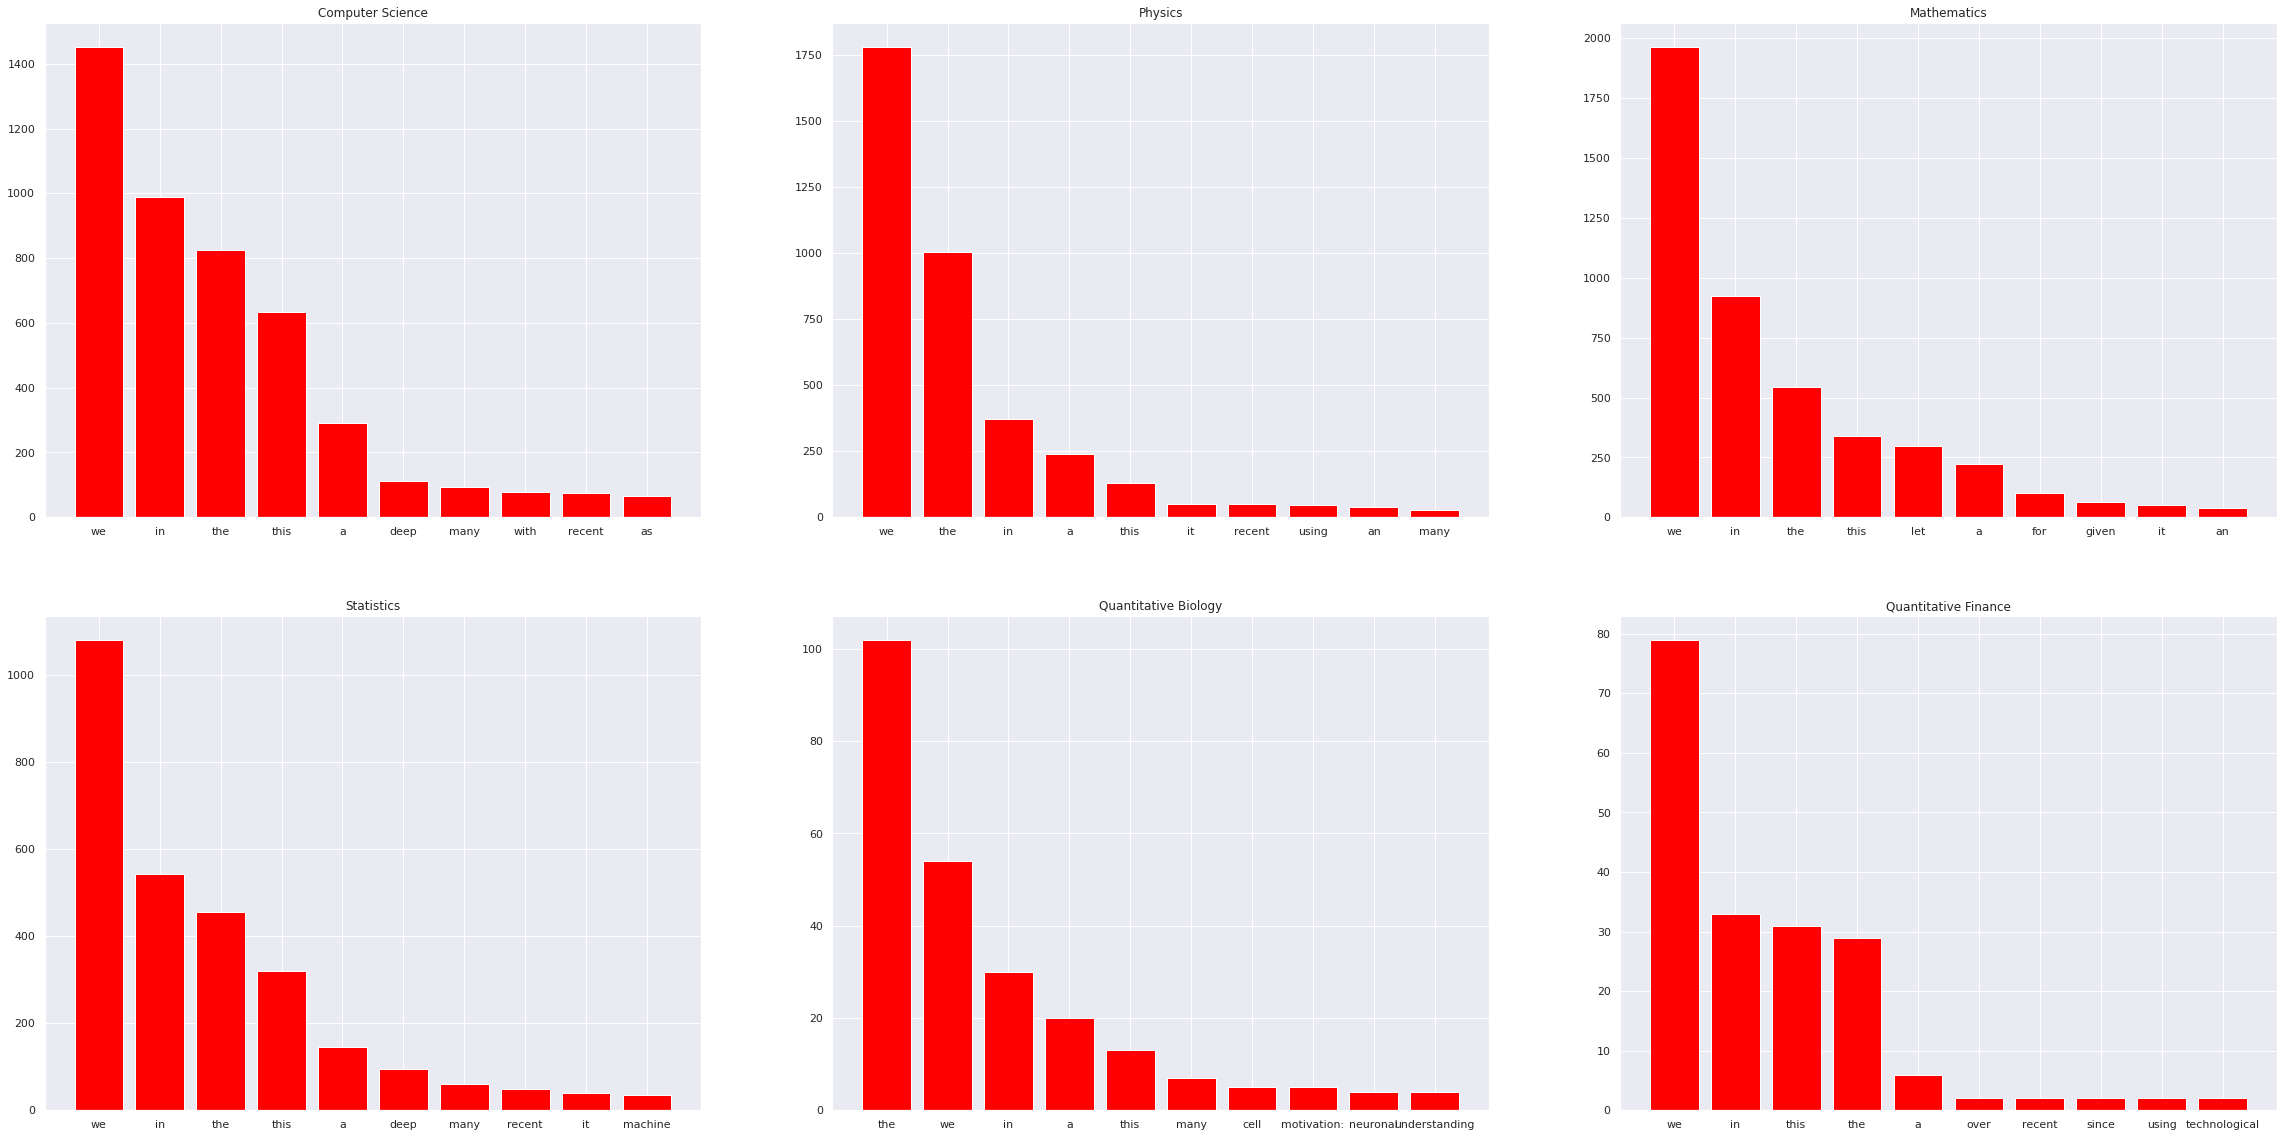

In [28]:
fig, axes = plt.subplots(2, 3,figsize=(40,20))
for i,label in enumerate (labels):
  x,y=top_first_word_abstract(df_train,label)
  axes[i//3,i%3].set_title(label)
  axes[i//3,i%3].bar(x,y,width = 0.8,color='red')

#2.Data Cleaning

In [29]:
def lower_text(text):
  df=text.str.lower()
  return df

In [30]:
def remove_punctuations(text):
    #replace every punctuation with a whitespace to keep the words correct
    text = re.sub(r'[^\w\s]',' ',text)
    #remove the successive whitespaces
    _RE_COMBINE_WHITESPACE = re.compile(r"\s+")
    no_punc = _RE_COMBINE_WHITESPACE.sub(" ", text).strip()
    return no_punc

In [31]:
def decontracted(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text


In [32]:
def remove_stop_words(text):
    #dict containing english stop words
    stop_words = {'ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there', 'about', 'once',
               'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 'some', 
                'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 'other', 
                'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each',
                'the', 'themselves', 'until', 'below', 'are', 'we', 'these', 'your', 'his', 'through', 
                'don', 'nor', 'me', 'were', 'her', 'more', 'himself', 'this', 'down', 'should', 'our', 
                'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'no', 
                'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 
                'will', 'on', 'does', 'yourselves', 'then', 'that', 'because', 'what', 'over', 'why', 
                'so', 'can', 'did', 'not', 'now', 'under', 'he', 'you', 'herself', 'has', 'just', 
                'where', 'too', 'only', 'myself', 'which', 'those', 'i', 'after', 'few', 'whom', 't', 
                'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further',
                'was', 'here', 'than'}
  
  #we need to get rid of some special characters
    text = re.sub(r"\x89Û_", "", text)
    text = re.sub(r"\x89ÛÒ", "", text)
    text = re.sub(r"\x89ÛÓ", "", text)

  #convert all the text to lowercase
    text = text.lower()
    sentence_list = text.split()
    new_sentence = []


  
    for word in sentence_list:
        for stop_word in stop_words:
            if (stop_word == word):
                word = re.sub(stop_word, '', word)
        new_sentence.append(word) 
    return (" ".join(new_sentence))

In [33]:
#this function removes emojis 
#as well as emoticons (representation of a human facial expression using only keyboard characters :D )
#Installing emot library
!pip install emot
#Importing libraries
import re
from emot.emo_unicode import UNICODE_EMO, EMOTICONS

def remove_emojis(text):
    sentence = text.split()
    new_sentence = []
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in EMOTICONS) + u')')

    #since we have an emoticon ":/" as substing in any url, we need to prevent replacing it 
    url_keep_pattern = re.compile("https?://")
  
    for w in sentence :
        w = emoji_pattern.sub(r'', w)
        if (url_keep_pattern.match(w) is None): #if it's not a url
            w = emoticon_pattern.sub(r'', w)
        new_sentence.append(w)
  
  
    return (" ".join(new_sentence))

In [34]:
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    text = re.sub(clean, '', text)
    return text

In [35]:
def remove_urls (text):
    text = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', '', text)
    return text

In [36]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "after midday",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [37]:
def fix_slangs(text):
  #first of all we need to change our text to lowercase to match the abbreviations, otherwise some words won't be changed
  #eg: NYC
    text = text.lower()
    sentence_list = text.split()
    new_sentence = []
    
    for word in sentence_list:
        for candidate_replacement in abbreviations:
            if (candidate_replacement == word):
                word = word.replace(candidate_replacement, abbreviations[candidate_replacement])
        new_sentence.append(word) 
  
    return (" ".join(new_sentence))

In [38]:
def preprocessing(df):
  #df['TITLE']=df['TITLE'].apply(lower_text)
  #df['ABSTRACT']=df['ABSTRACT'].apply(lower_text)
  df['TITLE']=df['TITLE'].apply(remove_punctuations)
  df['ABSTRACT']=df['ABSTRACT'].apply(remove_punctuations)
  df['TITLE']=df['TITLE'].apply(decontracted)
  df['ABSTRACT']=df['ABSTRACT'].apply(decontracted)
  df['TITLE']=df['TITLE'].apply(remove_stop_words)
  df['ABSTRACT']=df['ABSTRACT'].apply(remove_stop_words)
  df['TITLE']=df['TITLE'].apply(remove_emojis)
  df['ABSTRACT']=df['ABSTRACT'].apply(remove_emojis)
  df['TITLE']=df['TITLE'].apply(remove_html_tags)
  df['ABSTRACT']=df['ABSTRACT'].apply(remove_html_tags)
  df['TITLE']=df['TITLE'].apply(remove_urls)
  df['ABSTRACT']=df['ABSTRACT'].apply(remove_urls)
  df['TITLE']=df['TITLE'].apply(fix_slangs)
  df['ABSTRACT']=df['ABSTRACT'].apply(fix_slangs)
  return df

In [39]:
df_clean=preprocessing(df_train)

In [40]:
df_clean

,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
ID,,,,,,,,
1,reconstructing subject specific effect maps,predictive models allow subject specific infer...,1,0,0,0,0,0
2,rotation invariance neural network,rotation invariance translation invariance gre...,1,0,0,0,0,0
3,spherical polyharmonics poisson kernels polyha...,introduce develop notion spherical polyharmoni...,0,0,1,0,0,0
4,finite element approximation stochastic maxwel...,stochastic landau lifshitz gilbert llg equatio...,0,0,1,0,0,0
5,comparative study discrete wavelet transforms ...,fourier transform infra red ftir spectra sampl...,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...
20968,contemporary machine learning guide practition...,machine learning finding increasingly broad ap...,1,1,0,0,0,0
20969,uniform diamond coatings wc co hard alloy cutt...,polycrystalline diamond coatings grown cemente...,0,1,0,0,0,0
20970,analysing soccer games clustering conceptors,present new approach identifying situations be...,1,0,0,0,0,0


#3.CountVectorizer


In [41]:
X=df_clean.drop(labels,axis=1)
y=df_clean[labels]

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [43]:
def code_cv (X):
  cv=CountVectorizer()
  X_abstract=X['ABSTRACT']
  X_title=X['TITLE']
  X_abstract_cv=cv.fit_transform(X_abstract)
  X_title_cv=cv.transform(X_title)
  X_cv=hstack([X_title_cv,X_abstract_cv])
  return X_cv

In [44]:
X_CV=code_cv(X)

In [45]:
def plot_PCA(X,y):
  colors=['red','green']
  fig, axes = plt.subplots(2, 3,figsize=(15,10))
  new_y=[]
  for item in y.values:
    new_y.append(np.nonzero(item)[0][0])
  for i in range (6):
    svd = TruncatedSVD(n_components=2)
    X_svd=svd.fit_transform(X)
    data={'X1':X_svd[:,0],'X2':X_svd[:,1],'y':new_y}
    data=pd.DataFrame(data)
    X1=data[data['y']==i]
    X2=data[data['y']!=i]
    axes[i//3,i%3].scatter(X1['X1'].values,X1['X2'].values,color='green',s=1, alpha=1)
    axes[i//3,i%3].scatter(X2['X1'].values,X2['X2'].values,c = 'red',s=1, alpha=0.1)
    axes[i//3,i%3].set_facecolor('black')
  plt.show()



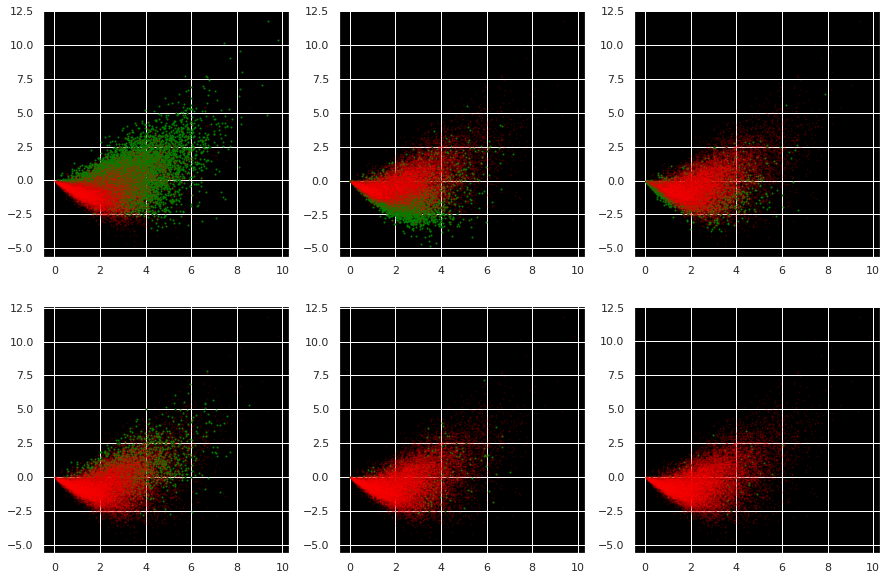

In [46]:
plot_PCA(X_CV,y)

#4.tf-idf

In [47]:
def code_tf_idf(X):
  vectorizer = TfidfVectorizer()
  X_abstract=X['ABSTRACT']
  X_title=X['TITLE']
  X_abstract_cv=vectorizer.fit_transform(X_abstract)
  X_title_cv=vectorizer.transform(X_title)
  X_tf_idf=hstack([X_title_cv,X_abstract_cv])
  return X_tf_idf

In [48]:
X_tf_idf=code_tf_idf(X)

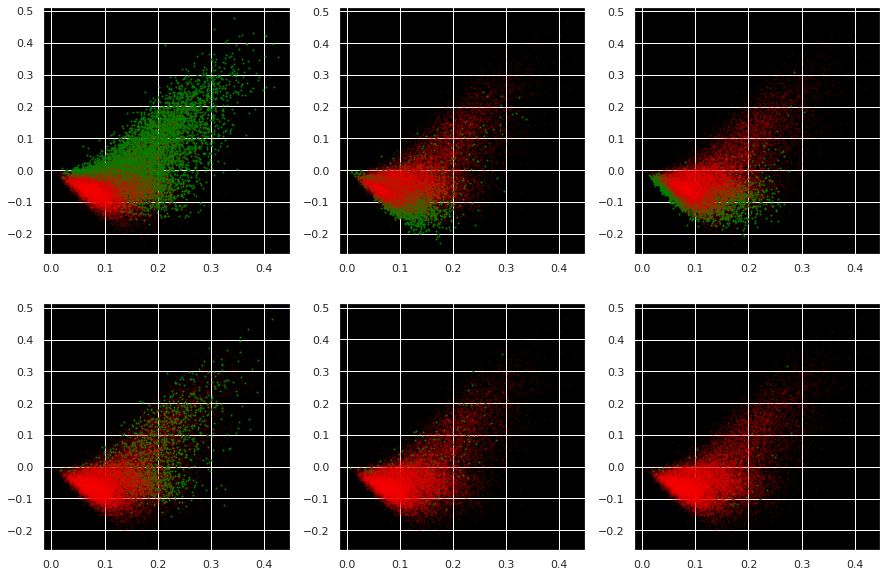

In [49]:
plot_PCA(X_tf_idf,y)

#5.Word2Vec

In [50]:
def create_corpus_new(df):
  word_matrix=[]
  for i in range (df.shape[0]):
    words=[]
    for word in df.values[i].split():
      words.append(word)
    word_matrix.append(words)
  return word_matrix

In [51]:
corpus_abstract=create_corpus_new(df_clean['ABSTRACT'])
corpus_title=create_corpus_new(df_clean['TITLE'])

In [52]:
def get_pad(corpus,maxlen):
  MAXLEN=maxlen
  tokenizer_obj=Tokenizer()
  tokenizer_obj.fit_on_texts(corpus_abstract)
  sequences=tokenizer_obj.texts_to_sequences(corpus)
  corpus_pad=pad_sequences(sequences,maxlen=MAXLEN)
  vocab=tokenizer_obj.word_index
  return corpus_pad,vocab


In [53]:
pad_abstract,vocab_abstract=get_pad(corpus_abstract,128)
pad_title,vocab_title=get_pad(corpus_title,32)

In [54]:
X_pad=np.hstack((pad_title,pad_abstract))

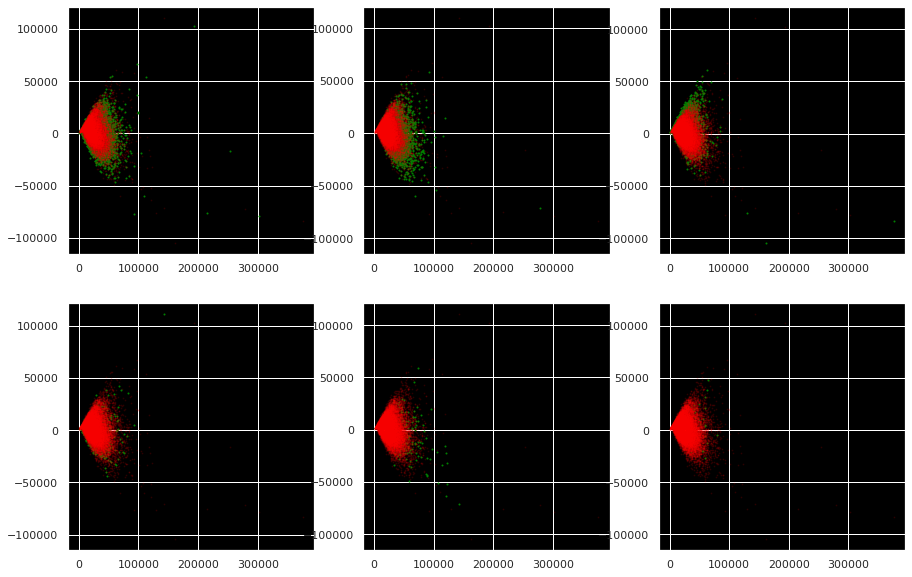

In [55]:
plot_PCA(X_pad,y)

In [56]:
corpus=corpus_abstract+corpus_title

In [57]:
EMBEDDING_DIM=160
w2v_model = Word2Vec(
    min_count=1,
    window=5,
    size=EMBEDDING_DIM,
    negative=10,
    alpha=0.03,
    min_alpha=0.0007,
    sample=6e-5,
    sg=1)
w2v_model.build_vocab(corpus)
w2v_model.train(corpus, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(43185025, 65810190)

In [58]:
from keras.utils import np_utils
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from collections import defaultdict
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
from keras.layers.embeddings import Embedding
from keras.preprocessing import text, sequence

#6.RNN

In [59]:
#metric
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [60]:
X_train,X_test,y_train,y_test=train_test_split(X_pad,y)

In [61]:
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab)+1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [77]:
embedding_vectors = get_weight_matrix(w2v_model, vocab_abstract)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [78]:
vocab_size=len(vocab_abstract)+1

In [79]:
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=160, trainable=True))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.3,return_sequences = True)))
model.add(Bidirectional(GRU(units=32 , recurrent_dropout = 0.1 , dropout = 0.1)))
model.add(Dense(6, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=[get_f1])

del embedding_vectors

In [80]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 160, 160)          8874240   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 160, 256)          295936    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                55680     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
Total params: 9,226,246
Trainable params: 9,226,246
Non-trainable params: 0
_________________________________________________________________


In [81]:
history = model.fit(X_train, y_train, batch_size = 1024 , validation_data = (X_test,y_test) , epochs = 5)

Epoch 1/5
16/16 [==============================] - 45s 2s/step - loss: 0.4681 - get_f1: 0.2664 - val_loss: 0.2684 - val_get_f1: 0.7383
Epoch 2/5
16/16 [==============================] - 36s 2s/step - loss: 0.2643 - get_f1: 0.7292 - val_loss: 0.2429 - val_get_f1: 0.7682
Epoch 3/5
16/16 [==============================] - 36s 2s/step - loss: 0.2197 - get_f1: 0.7874 - val_loss: 0.2076 - val_get_f1: 0.8044
Epoch 4/5
16/16 [==============================] - 36s 2s/step - loss: 0.1767 - get_f1: 0.8325 - val_loss: 0.1951 - val_get_f1: 0.8145
Epoch 5/5
16/16 [==============================] - 35s 2s/step - loss: 0.1393 - get_f1: 0.8707 - val_loss: 0.1943 - val_get_f1: 0.8143


#7.Logistic Regression

In [82]:
def fit_model(X,y,labels,model,name_model):
  print ('model= {}'.format(name_model))
  X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
  for label in labels:
    model.fit(X_train,y_train[label])
    pred=model.predict(X_test)
    print ('F1 Score for {}'.format(label),f1_score(pred,y_test[label]))

  

In [83]:
clf=LogisticRegression(C=10.0,solver='lbfgs',class_weight='balanced', max_iter=1000)
fit_model(X_tf_idf,y,labels,clf,'Logistic_Regression')

model= Logistic_Regression
F1 Score for Computer Science 0.8203033838973162
F1 Score for Physics 0.8775425487754256
F1 Score for Mathematics 0.7996492766330557
F1 Score for Statistics 0.7677329624478443
F1 Score for Quantitative Biology 0.5089285714285715
F1 Score for Quantitative Finance 0.6216216216216216


#8.KNN

In [84]:
classifier_knn = KNeighborsClassifier(n_neighbors = 7,weights = 'distance',algorithm = 'brute')
fit_model(X_tf_idf,y,labels,classifier_knn,'KNN')

model= KNN
F1 Score for Computer Science 0.7863340563991323
F1 Score for Physics 0.7869626830420406
F1 Score for Mathematics 0.695128076343546
F1 Score for Statistics 0.6821158690176323
F1 Score for Quantitative Biology 0.14492753623188404
F1 Score for Quantitative Finance 0.26415094339622647


#9.DecisionTreeClassifier

In [85]:
classifier_dt = DecisionTreeClassifier(criterion= 'entropy',
                                           splitter='best', 
                                           random_state=55)
fit_model(X_tf_idf,y,labels,classifier_dt,'DecisionTreeClassifier')

model= DecisionTreeClassifier
F1 Score for Computer Science 0.697372305875406
F1 Score for Physics 0.7463295269168027
F1 Score for Mathematics 0.6663755458515284
F1 Score for Statistics 0.6159036144578313
F1 Score for Quantitative Biology 0.28054298642533937
F1 Score for Quantitative Finance 0.34567901234567905


#10.Future Engineering

In [86]:
df_clean

,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
ID,,,,,,,,
1,reconstructing subject specific effect maps,predictive models allow subject specific infer...,1,0,0,0,0,0
2,rotation invariance neural network,rotation invariance translation invariance gre...,1,0,0,0,0,0
3,spherical polyharmonics poisson kernels polyha...,introduce develop notion spherical polyharmoni...,0,0,1,0,0,0
4,finite element approximation stochastic maxwel...,stochastic landau lifshitz gilbert llg equatio...,0,0,1,0,0,0
5,comparative study discrete wavelet transforms ...,fourier transform infra red ftir spectra sampl...,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...
20968,contemporary machine learning guide practition...,machine learning finding increasingly broad ap...,1,1,0,0,0,0
20969,uniform diamond coatings wc co hard alloy cutt...,polycrystalline diamond coatings grown cemente...,0,1,0,0,0,0
20970,analysing soccer games clustering conceptors,present new approach identifying situations be...,1,0,0,0,0,0


In [87]:
def number_of_words(df):
  text_len_title=[]
  text_len_abstract=[]
  for title,abstract in zip(df_train['TITLE'].values,df_train['ABSTRACT'].values):
      text_len_title.append(len(title.split()))
      text_len_abstract.append(len(abstract.split()))
  data={'word_count_title':text_len_title,'word_count_abstract':text_len_abstract}
  data=pd.DataFrame(data)
  df.reset_index(inplace = True, drop = True)
  df=df[['TITLE','ABSTRACT']].join(data).join(df[labels])
  return df
  

In [88]:
df_new=number_of_words(df_clean)

In [89]:
df_new.head()

,TITLE,ABSTRACT,word_count_title,word_count_abstract,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,reconstructing subject specific effect maps,predictive models allow subject specific infer...,5,191,1,0,0,0,0,0
1,rotation invariance neural network,rotation invariance translation invariance gre...,4,53,1,0,0,0,0,0
2,spherical polyharmonics poisson kernels polyha...,introduce develop notion spherical polyharmoni...,6,58,0,0,1,0,0,0
3,finite element approximation stochastic maxwel...,stochastic landau lifshitz gilbert llg equatio...,9,70,0,0,1,0,0,0
4,comparative study discrete wavelet transforms ...,fourier transform infra red ftir spectra sampl...,15,87,1,0,0,1,0,0


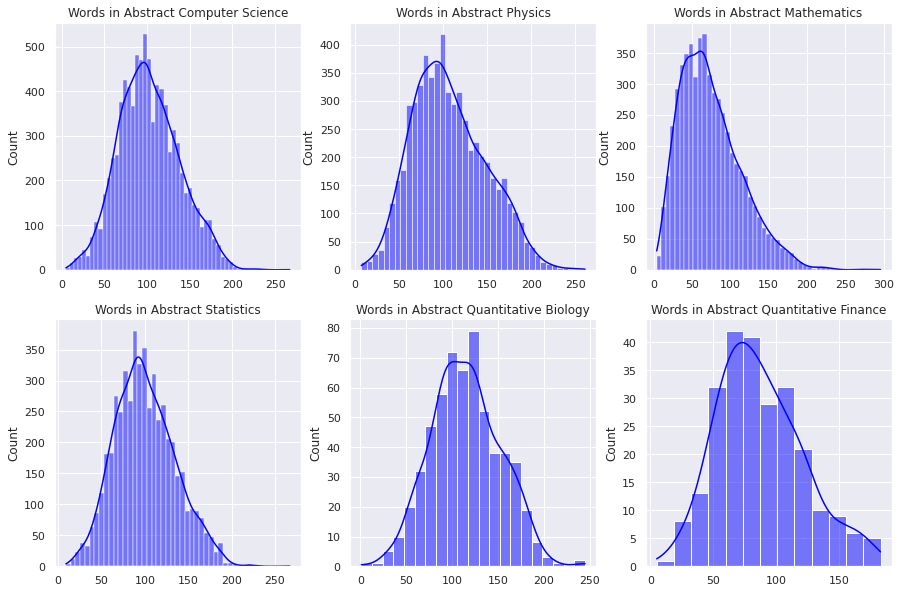

In [90]:
fig, axes = plt.subplots(2, 3,figsize=(15,10))
for i,label in enumerate (labels):
  word_abstract=[]
  for j,item in enumerate (df_new[label].values):
    if item==1:
      word_abstract.append(df_new['word_count_abstract'].values[j])
  sns.histplot(word_abstract,kde=True,ax=axes[i//3,i%3],color='blue')
  axes[i//3,i%3].set_title('Words in Abstract {}'.format(label))


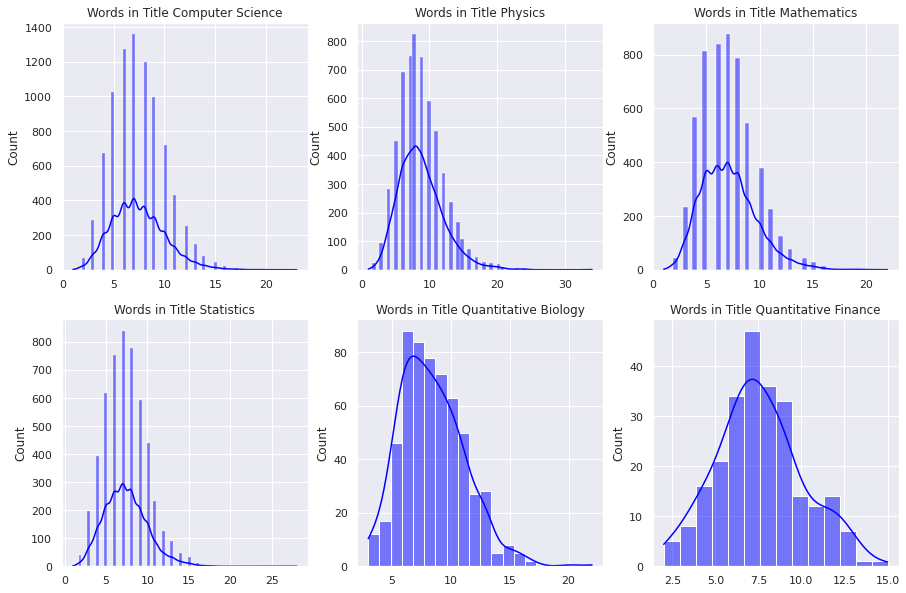

In [91]:
fig, axes = plt.subplots(2, 3,figsize=(15,10))
for i,label in enumerate (labels):
  word_title=[]
  for j,item in enumerate (df_new[label].values):
    if item==1:
      word_title.append(df_new['word_count_title'].values[j])
  sns.histplot(word_title,kde=True,ax=axes[i//3,i%3],color='blue')
  axes[i//3,i%3].set_title('Words in Title {}'.format(label))


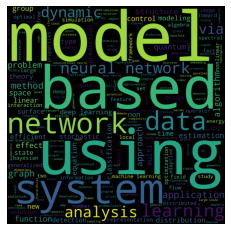

In [92]:
wordcloud2 = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2000,
                          height=2000
                         ).generate(" ".join(df_clean['TITLE']))


plt.imshow(wordcloud2)
plt.axis('off')
plt.show()

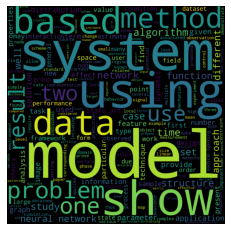

In [93]:
wordcloud2 = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2000,
                          height=2000
                         ).generate(" ".join(df_clean['ABSTRACT']))


plt.imshow(wordcloud2)
plt.axis('off')
plt.show()

In [94]:
X1=np.vstack (( df_new['word_count_title'].values/max(df_new['word_count_title'].values),df_new['word_count_abstract'].values/max(df_new['word_count_abstract'].values))).T

In [95]:
X1=hstack((X_tf_idf,csr_matrix(X1)))

In [96]:
df_clean.iloc[:,0:2]

,TITLE,ABSTRACT
0,reconstructing subject specific effect maps,predictive models allow subject specific infer...
1,rotation invariance neural network,rotation invariance translation invariance gre...
2,spherical polyharmonics poisson kernels polyha...,introduce develop notion spherical polyharmoni...
3,finite element approximation stochastic maxwel...,stochastic landau lifshitz gilbert llg equatio...
4,comparative study discrete wavelet transforms ...,fourier transform infra red ftir spectra sampl...
...,...,...
20967,contemporary machine learning guide practition...,machine learning finding increasingly broad ap...
20968,uniform diamond coatings wc co hard alloy cutt...,polycrystalline diamond coatings grown cemente...
20969,analysing soccer games clustering conceptors,present new approach identifying situations be...
20970,efficient simulation left tail sum correlated ...,sum log normal variates encountered many chall...


In [97]:
def append_first_word(df,df1,name,i):
  first_word=[]
  for seq in df1.str.split():
    first_word.append(seq[0].lower())
  data={'first_word_{}'.format(name):first_word}
  data=pd.DataFrame(data)
  df.reset_index(inplace = True, drop = True)
  df=df.iloc[:,0:i].join(data).join(df[labels])
  return df

In [98]:
new_df=append_first_word(df_clean,df_clean['TITLE'],'title',2)
new_df=append_first_word(new_df,df_clean['ABSTRACT'],'abstract',3)

In [99]:
new_df

,TITLE,ABSTRACT,first_word_title,first_word_abstract,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,reconstructing subject specific effect maps,predictive models allow subject specific infer...,reconstructing,predictive,1,0,0,0,0,0
1,rotation invariance neural network,rotation invariance translation invariance gre...,rotation,rotation,1,0,0,0,0,0
2,spherical polyharmonics poisson kernels polyha...,introduce develop notion spherical polyharmoni...,spherical,introduce,0,0,1,0,0,0
3,finite element approximation stochastic maxwel...,stochastic landau lifshitz gilbert llg equatio...,finite,stochastic,0,0,1,0,0,0
4,comparative study discrete wavelet transforms ...,fourier transform infra red ftir spectra sampl...,comparative,fourier,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
20967,contemporary machine learning guide practition...,machine learning finding increasingly broad ap...,contemporary,machine,1,1,0,0,0,0
20968,uniform diamond coatings wc co hard alloy cutt...,polycrystalline diamond coatings grown cemente...,uniform,polycrystalline,0,1,0,0,0,0
20969,analysing soccer games clustering conceptors,present new approach identifying situations be...,analysing,present,1,0,0,0,0,0
20970,efficient simulation left tail sum correlated ...,sum log normal variates encountered many chall...,efficient,sum,0,0,1,1,0,0


In [100]:
vectorizer = TfidfVectorizer()
X_abstract=new_df['ABSTRACT']
X_title=new_df['TITLE']
X_first_word_title=new_df['first_word_title']
X_first_word_abstract=new_df['first_word_abstract']
X_abstract_tf=vectorizer.fit_transform(X_abstract)
X_title_tf=vectorizer.fit_transform(X_title)
X_first_word_title_tf=vectorizer.fit_transform(X_first_word_title)
X_first_word_abstract_tf=vectorizer.fit_transform(X_first_word_abstract)

In [101]:
X1=hstack((X_abstract_tf,X_title_tf,X_first_word_title_tf,X_first_word_abstract_tf))

In [102]:
fit_model(X1,y,labels,clf,'Logistic Regression')

model= Logistic Regression
F1 Score for Computer Science 0.8108581436077058
F1 Score for Physics 0.8711707931179186
F1 Score for Mathematics 0.7844865579550464
F1 Score for Statistics 0.7563499529633114
F1 Score for Quantitative Biology 0.416243654822335
F1 Score for Quantitative Finance 0.6285714285714286


# 11.Submission

In [104]:
df_test_clean=preprocessing(df_test)

In [105]:
corpus_abstract_test=create_corpus_new(df_test_clean['ABSTRACT'])
corpus_title_test=create_corpus_new(df_test_clean['TITLE'])

In [106]:
pad_abstract_test,vocab_abstract_test=get_pad(corpus_abstract_test,128)
pad_title_test,vocab_title_test=get_pad(corpus_title_test,32)

In [107]:
X_pad_test=np.hstack((pad_title_test,pad_abstract_test))

In [114]:
preds=model.predict(X_pad_test)

In [115]:
preds

array([[2.8925368e-01, 4.3988932e-02, 3.7575174e-02, 9.1242576e-01,
        2.7461452e-02, 1.6237698e-02],
       [9.0402411e-03, 9.9453968e-01, 5.4817954e-03, 3.0975849e-03,
        2.8812550e-03, 1.4379820e-03],
       [9.7642773e-01, 4.3740366e-03, 3.5871089e-02, 1.3626707e-01,
        3.1764370e-03, 4.2958907e-03],
       ...,
       [1.2774791e-01, 1.3728909e-01, 3.1560205e-02, 6.0811085e-01,
        4.5877254e-01, 5.2387320e-02],
       [7.9389721e-01, 6.5390198e-03, 2.1527345e-01, 6.3054085e-01,
        2.7691491e-03, 7.7634738e-03],
       [9.2242950e-01, 4.6740500e-03, 6.1662900e-01, 1.9902155e-02,
        2.1925110e-04, 2.5937979e-03]], dtype=float32)

In [116]:
submission=pd.read_csv('/content/sample_submission.csv')

In [125]:
data={'ID':submission['ID'].values,
    'Computer Science':preds[:,0],
      'Physics':preds[:,1],
      'Mathematics':preds[:,2],
      'Statistics':preds[:,3],
      'Quantitative Biology':preds[:,4],
      'Quantitative Finance':preds[:,5]}
submission=pd.DataFrame(data)

In [126]:
submission

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,20973,0.289254,0.043989,0.037575,0.912426,0.027461,0.016238
1,20974,0.009040,0.994540,0.005482,0.003098,0.002881,0.001438
2,20975,0.976428,0.004374,0.035871,0.136267,0.003176,0.004296
3,20976,0.010955,0.994365,0.005260,0.002704,0.002450,0.001176
4,20977,0.964384,0.029421,0.175878,0.005643,0.000819,0.002843
...,...,...,...,...,...,...,...
8984,29957,0.974503,0.009396,0.064227,0.090068,0.002994,0.003607
8985,29958,0.764435,0.001453,0.887733,0.133682,0.000447,0.003948
8986,29959,0.127748,0.137289,0.031560,0.608111,0.458773,0.052387
8987,29960,0.793897,0.006539,0.215273,0.630541,0.002769,0.007763


In [128]:
submission.to_csv('submission_JetBrain.csv',index=False)